In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
import getpass
%matplotlib inline

In [2]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="root",
                       passwd=getpass.getpass(),
                       db="olist")

········


# Time Series

We start by looking at a crucial component of our business - the number of incoming orders

## No. of Orders

I want to have the date as a date id and number of orders, after 2017-0-01

|  date_id  |number of orders  |
|-----------|------------------|
| 2017-01-2 | 83737|

In [3]:
daily_orders_query = """
SELECT 
    DATE(order_purchase_timestamp)  AS date_id,
    COUNT(order_id)                 AS no_of_orders
FROM olist.orders o 
WHERE order_purchase_timestamp > '2017-01-01'
GROUP BY 1
ORDER BY 1
"""
daily_orders = pd.read_sql(daily_orders_query, conn)

In [4]:
daily_orders.head()

,date_id,no_of_orders
0,2017-01-05,32
1,2017-01-06,3
2,2017-01-07,5
3,2017-01-08,6
4,2017-01-09,5


In [5]:
daily_orders.dtypes

date_id         object
no_of_orders     int64
dtype: object

In [6]:
daily_orders["date_id"] = pd.to_datetime(daily_orders["date_id"])

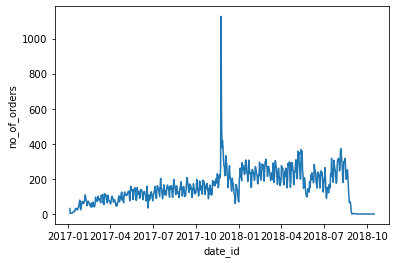

In [7]:
sns.lineplot(data=daily_orders,
             x="date_id",
             y="no_of_orders");

Too much detail - next we can try to look at the per week data!

In [8]:
weekly_orders = daily_orders.copy()

In [9]:
#one way to get week number
weekly_orders = weekly_orders.assign(week_id=weekly_orders["date_id"].dt.isocalendar().week)

In [10]:
weekly_orders.head()

,date_id,no_of_orders,week_id
0,2017-01-05,32,1
1,2017-01-06,3,1
2,2017-01-07,5,1
3,2017-01-08,6,1
4,2017-01-09,5,2


Here we will look at another way to get the week information. Instead of looking specifically at the week_id, we will try to force every week back to the first day of the week. We will do this by subtracting the day of the week from the date_id. 

In [12]:
weekly_orders = weekly_orders.assign(day_of_week=weekly_orders["date_id"].dt.dayofweek)

In [15]:
weekly_orders = weekly_orders.assign(week_year=weekly_orders["date_id"] 
                                     - pd.to_timedelta(weekly_orders["date_id"]
                                                       .dt.dayofweek, unit="D"))

In [16]:
weekly_orders.head()

,date_id,no_of_orders,week_id,day_of_week,week_year
0,2017-01-05,32,1,3,2017-01-02
1,2017-01-06,3,1,4,2017-01-02
2,2017-01-07,5,1,5,2017-01-02
3,2017-01-08,6,1,6,2017-01-02
4,2017-01-09,5,2,0,2017-01-09


If we wanted to continue to use `week_id` we would need to add the year. For now, we will continue on with the `week_year` column.

In [18]:
weekly_orders = (weekly_orders.groupby("week_year")
                              .agg({"no_of_orders":"sum"})
                              .reset_index())

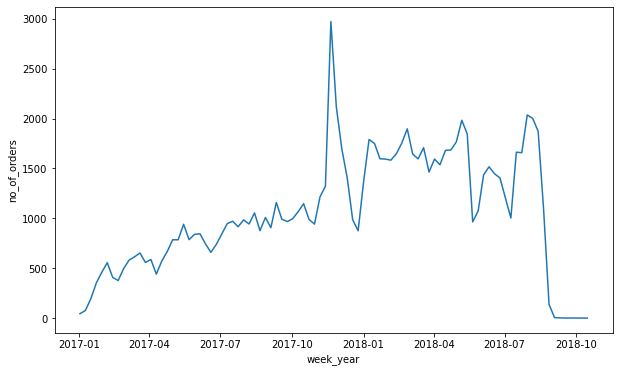

In [21]:
fig, ax = plt.subplots(figsize=(10,6)) #used matplotlib to change fig size
sns.lineplot(data=weekly_orders,
             x="week_year",
             y="no_of_orders");

A bit better than per day, but maybe per month would be better. There is still more variance than necessary.

In [22]:
monthly_orders = daily_orders.copy()

In [23]:
monthly_orders.head()

,date_id,no_of_orders
0,2017-01-05,32
1,2017-01-06,3
2,2017-01-07,5
3,2017-01-08,6
4,2017-01-09,5


In [24]:
monthly_orders.dtypes

date_id         datetime64[ns]
no_of_orders             int64
dtype: object

In [29]:
#in order to have a datetime object, we need to have a day
monthly_orders = (monthly_orders
                  .assign(month_id=pd.to_datetime(monthly_orders["date_id"].dt.strftime("%Y-%m-01")))
                  .groupby("month_id")
                  .agg({"no_of_orders":"sum"})
 #                       "other_column":"count",
#                        "other_column": np.sum})
                  .reset_index())

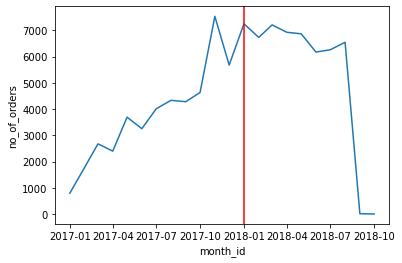

In [33]:
ax = sns.lineplot(data=monthly_orders,
             x="month_id",
             y="no_of_orders");
ax.axvline(pd.to_datetime("2018-01-01"), color="r");

2017 is mostly rising, 2018 is plateauing or decreasing slightly.

Number of orders in each month, by year:

| year | month | no_of_orders|
|------|-------|-------------|
| 2017 | 1     | 239470      |

In [43]:
monthly_orders

,month_id,no_of_orders,year,month
0,2017-01-01,798,2017,1
1,2017-02-01,1780,2017,2
2,2017-03-01,2678,2017,3
3,2017-04-01,2402,2017,4
4,2017-05-01,3695,2017,5
5,2017-06-01,3256,2017,6
6,2017-07-01,4013,2017,7
7,2017-08-01,4337,2017,8
8,2017-09-01,4285,2017,9
9,2017-10-01,4636,2017,10


In [37]:
monthly_orders["month_id"].dt.year

0     2017
1     2017
2     2017
3     2017
4     2017
5     2017
6     2017
7     2017
8     2017
9     2017
10    2017
11    2017
12    2018
13    2018
14    2018
15    2018
16    2018
17    2018
18    2018
19    2018
20    2018
21    2018
Name: month_id, dtype: int64

In [38]:
monthly_orders["month_id"].dt.month

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12     1
13     2
14     3
15     4
16     5
17     6
18     7
19     8
20     9
21    10
Name: month_id, dtype: int64

In [41]:
monthly_orders = (monthly_orders.assign(year=monthly_orders["month_id"].dt.year)
                .assign(month=monthly_orders["month_id"].dt.month))

In [45]:
#exclude where months are incomplete
monthly_orders = monthly_orders.loc[monthly_orders["month_id"] < "2018-09-01"]

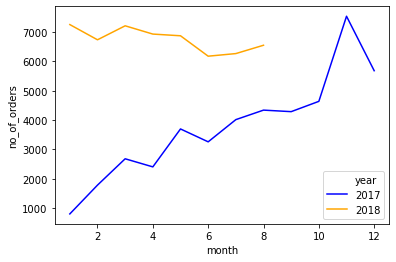

In [51]:
sns.lineplot(data=monthly_orders,
             x="month",
             y="no_of_orders",
             hue="year",
             palette=["blue", "orange"]);

- 2018 is doing better than 2017
- 2017 is a year of growth, so they are building up the business and have spikes in holiday seasons
- 2018 could be a stabilizing year - could go up again aroud Q3 or Q4 but we cant see

yoy - year over year
mom - month over month

Show the same graph for other metrics

Number of orders, Number of Sellers, Number of items sold, and Revenue 
- after 2017-01-01 before 2018-09-01
| month | year | orders | items_sold | sellers |revenue |
|-------|------|--------|-----------|----------|---------|

In [52]:
monthly_perf_query = """
SELECT 
	YEAR(o.order_purchase_timestamp)		AS year,
	MONTH(o.order_purchase_timestamp)		AS month, 
	COUNT(DISTINCT o.order_id)				AS orders,
	SUM(1)									AS items_sold,
	COUNT(DISTINCT oi.seller_id)			AS sellers,
	SUM(oi.price)							AS revenue
FROM olist.orders o
	INNER JOIN olist.order_items oi 
	ON o.order_id = oi.order_id 
WHERE o.order_purchase_timestamp >= '2017-01-01'
	AND o.order_purchase_timestamp < '2018-09-01'
GROUP BY 1, 2
"""

In [53]:
month_perf = pd.read_sql(monthly_perf_query, conn)

In [54]:
month_perf

,year,month,orders,items_sold,sellers,revenue
0,2017,1,787,952.0,227,1.198089e+05
1,2017,2,1733,1952.0,427,2.476922e+05
2,2017,3,2637,2996.0,499,3.736766e+05
3,2017,4,2389,2682.0,506,3.599871e+05
4,2017,5,3655,4128.0,583,5.047740e+05
5,2017,6,3228,3597.0,541,4.348993e+05
6,2017,7,3956,4501.0,604,4.968049e+05
7,2017,8,4300,4922.0,708,5.740459e+05
8,2017,9,4242,4827.0,730,6.248995e+05
9,2017,10,4573,5329.0,776,6.645821e+05
